In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import copy

#import skimage.io as io
from scipy.misc import bytescale

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Permute
from keras.layers import Convolution2D, Deconvolution2D, Cropping2D
from keras.layers import merge

Using TensorFlow backend.


In [3]:
from fcn_keras2 import fcn32_blank, fcn_32s_to_8s, prediction

## Build model architecture

### Paper 1 : Conditional Random Fields as Recurrent Neural Networks
##### Shuai Zheng, Sadeep Jayasumana, Bernardino Romera-Paredes, Vibhav Vineet, Zhizhong Su
##### Dalong Du, Chang Huang, Philip H. S. Torr

http://www.robots.ox.ac.uk/~szheng/papers/CRFasRNN.pdf

### Paper 2 : Efficient Inference in Fully Connected CRFs with Gaussian Edge Potentials
##### Philipp Krahenbuhl, Vladlen Koltun

https://arxiv.org/pdf/1210.5644.pdf

This paper specifies the CRF kernels and the Mean Field Approximation of the CRF energy function


### WARNING :
#### In v1 of this script we will only implement the FCN-8s subcomponent of the CRF-RNN network

#### Quotes from MatConvNet page (http://www.vlfeat.org/matconvnet/pretrained/#semantic-segmentation) :
*These networks are trained on the PASCAL VOC 2011 training and (in part) validation data, using Berekely's extended annotations, as well as Microsoft COCO.*

*While the CRF component is missing (it may come later to MatConvNet), this model still outperforms the FCN-8s network above, partially because it is trained with additional data from COCO.*

*The model was obtained by first fine-tuning the plain FCN-32s network (without the CRF-RNN part) on COCO data, then building built an FCN-8s network with the learnt weights, and finally training the CRF-RNN network end-to-end using VOC 2012 training data only. The model available here is the FCN-8s part of this network (without CRF-RNN, while trained with 10 iterations CRF-RNN).*

In [4]:
image_size = 64*8

In [5]:
fcn32model = fcn32_blank(image_size)

In [6]:
#print(dir(fcn32model.layers[-1]))
print(fcn32model.layers[-1].output_shape)

(None, 32, 32, 21)


In [7]:
fcn8model = fcn_32s_to_8s(fcn32model)

In [8]:
fcn8model.summary() # visual inspection of model architecture

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_1_input (InputLayer)     (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 512, 512, 3)   0           permute_1_input[0][0]            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 512, 512, 64)  1792        permute_1[0][0]                  
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 512, 512, 64)  36928       conv1_1[0][0]                    
___________________________________________________________________________________________

## Load VGG weigths from .mat file

#### https://www.vlfeat.org/matconvnet/pretrained/#semantic-segmentation
##### Download from console with :
wget http://www.vlfeat.org/matconvnet/models/pascal-fcn8s-tvg-dag.mat

In [9]:
from scipy.io import loadmat

In [10]:
USETVG = True
if USETVG:
    data = loadmat('pascal-fcn8s-tvg-dag.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    p = data['params']
    description = data['meta'][0,0].classes[0,0].description
else:
    data = loadmat('pascal-fcn8s-dag.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    p = data['params']
    description = data['meta'][0,0].classes[0,0].description
    print(data.keys())

In [11]:
l.shape, p.shape, description.shape

((1, 46), (1, 40), (1, 21))

In [12]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [13]:
if False: # inspection of data structure
    print(dir(l[0,31].block[0,0]))
    print(dir(l[0,44].block[0,0]))

if False:
    print (str(l[0,36].block[0,0].upsample) + " " + str(l[0,36].block[0,0].size))
    print (str(l[0,40].block[0,0].upsample) + " " + str(l[0,40].block[0,0].size))
    print (str(l[0,44].block[0,0].upsample) + " " + str(l[0,44].block[0,0].size) + " " + str(l[0,44].block[0,0].crop))
    
if False:
    for i in range(0, p.shape[1]-1-2*2, 2): # weights #36 to #37 are not all paired
        print('{0} {1} {2} {3} {4}'.format(i,
              p[0,i].name[0], p[0,i].value.shape,
              p[0,i+1].name[0], p[0,i+1].value.shape))
    print ('------------------------------------------------------')
    for i in range(p.shape[1]-1-2*2+1, p.shape[1]): # weights #36 to #37 are not all paired
        print('{0} {1} {2}'.format(i, p[0,i].name[0], p[0,i].value.shape))
    
if False:
    for i in range(l.shape[1]):
        print('{0} {1} {2} {3} {4}'.format(i,
                              l[0,i].name[0], 
                              l[0,i].type[0],
                              [str(n[0]) for n in l[0,i].inputs[0,:]],
                              [str(n[0]) for n in l[0,i].outputs[0,:]]))

In [14]:
def copy_mat_to_keras(kmodel, verbose=True):
    kerasnames = [lr.name for lr in kmodel.layers]
    prmt = (1,0,2,3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    for i in range(0, p.shape[1]):
        if USETVG:
            matname = p[0,i].name[0][0:-1]
            matname_type = p[0,i].name[0][-1] # "f" for filter weights or "b" for bias
        else:
            matname = p[0,i].name[0].replace('_filter','').replace('_bias','')
            matname_type = p[0,i].name[0].split('_')[-1] # "filter" or "bias"
        
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            if verbose:
                print ('found : {0} {1} {2}'.format(matname, matname_type, kindex))
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            
            if  matname_type in ['f','filter']:
                l_weights = p[0,i].value
                f_l_weights = l_weights.transpose(prmt)
                f_l_weights = np.flip(f_l_weights, 2)
                f_l_weights = np.flip(f_l_weights, 3)
                assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
                current_b = kmodel.layers[kindex].get_weights()[1]
                kmodel.layers[kindex].set_weights([f_l_weights, current_b])
            elif matname_type in ['b','bias']:
                l_bias = p[0,i].value
                assert (l_bias.shape[1] == 1)
                assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
                current_f = kmodel.layers[kindex].get_weights()[0]
                kmodel.layers[kindex].set_weights([current_f, l_bias[:,0]])
        else:
            print ('not found : ' + str(matname))

In [15]:
#copy_mat_to_keras(fcn32model)
copy_mat_to_keras(fcn8model, True)

found : conv1_1 f 2
found : conv1_1 b 2
found : conv1_2 f 3
found : conv1_2 b 3
found : conv2_1 f 5
found : conv2_1 b 5
found : conv2_2 f 6
found : conv2_2 b 6
found : conv3_1 f 8
found : conv3_1 b 8
found : conv3_2 f 9
found : conv3_2 b 9
found : conv3_3 f 10
found : conv3_3 b 10
found : conv4_1 f 12
found : conv4_1 b 12
found : conv4_2 f 13
found : conv4_2 b 13
found : conv4_3 f 14
found : conv4_3 b 14
found : conv5_1 f 16
found : conv5_1 b 16
found : conv5_2 f 17
found : conv5_2 b 17
found : conv5_3 f 18
found : conv5_3 b 18
found : fc6 f 20
found : fc6 b 20
found : fc7 f 21
found : fc7 b 21
found : score_fr f 22
found : score_fr b 22
found : score2 f 23
found : score2 b 23
found : score_pool4 f 24
found : score_pool4 b 24
found : score4 f 27
found : score_pool3 f 28
found : score_pool3 b 28
found : upsample f 31


## Tests

In [16]:
im = Image.open('rgb.jpg') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((image_size,image_size))

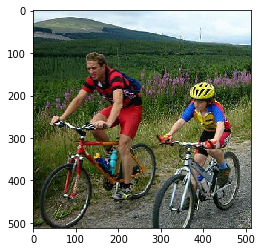

In [17]:
plt.imshow(np.asarray(im))

In [18]:
# WARNING : we do not deal with cropping here, this image is already fit
preds = prediction(fcn8model, im, transform=True)

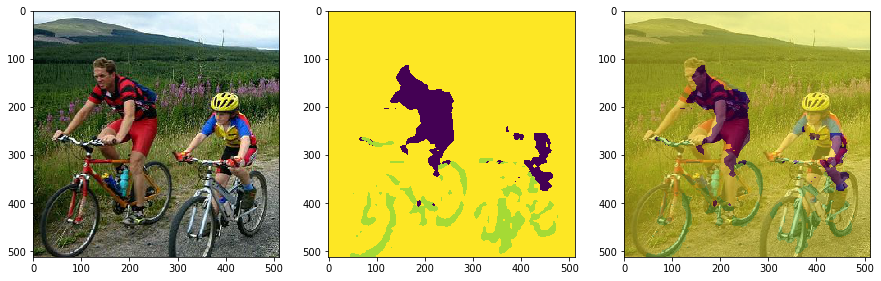

In [19]:
#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=3)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [20]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print (str(c) + " " + str(description[0,c][0]))

5 bottle
15 person
18 sofa
20 tvmonitor


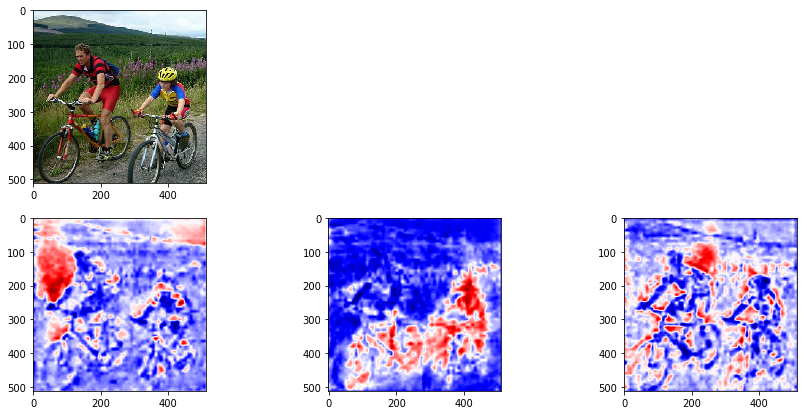

In [21]:
bspreds = bytescale(preds, low=0, high=255)

plt.figure(figsize = (15, 7))
plt.subplot(2,3,1)
plt.imshow(np.asarray(im))
plt.subplot(2,3,3+1)
plt.imshow(bspreds[0,:,:,class2index['background']], cmap='seismic')
plt.subplot(2,3,3+2)
plt.imshow(bspreds[0,:,:,class2index['person']], cmap='seismic')
plt.subplot(2,3,3+3)
plt.imshow(bspreds[0,:,:,class2index['bicycle']], cmap='seismic')